# Binary Classification with PyTorch 

In this training, we will use PyTorch to build a simple neural network for binary classification. We will use the `torch` and `torchvision` libraries to build and train the model. We will use the `sklearn` library to evaluate the model. 
The outcome of the model will predict if the Total Row score C of a patient is above or below a certain value, in this case we have defined the threshold as 5 e.g. if the Total Row score C is above 5, the outcome is class 1, otherwise it is  class 0.


In [1]:
# import libraries
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization, Dropout
import sklearn
import keras
from tensorflow.keras.optimizers.legacy import Adam
from scikeras.wrappers import KerasRegressor
from keras.layers import Dropout
from keras.utils import to_categorical
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf
import torch
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from keras import regularizers
np.random.seed(7)

### We then need to define some functions to help with the classification 
We will define the following functions: `pin_update`: this function makes a returns a 1 if the total row score is below 5 or else a 0. \
Then `pin_update1`: This function return a 1 is the total row score is above 5 or else a 0. \
Then we have created `predict_round` which is a function that returns the rounded value of the prediction, and the estimated class

In [2]:
def pin_update(row):
    if row["Total Row Score C"] <= 5:
        return 0
    else:
        return 1


def pin_update1(row):
     if 5 < row["Total Row Score C"]:
          return 0
     else:
          return 1


def predict_round(pred):
    if pred[0] > pred[1]:
        return f"the estimate would be class 1 with a probability of {pred[0]*100}"
    else: 
        return f"The estimate would be class 2 with a probability of {pred[1]*100}"

Here data is loaded in from the Databehandling jupyter notebook.

In [3]:
df = pd.read_csv('Data for python.csv', sep=';', header=1, index_col=0, decimal=',')
df = df.drop(columns=['Id'])
df = df.drop(columns=['ScandcleftID'])
df = df.drop(columns=['Født'])
df = df.drop(columns=['Materialedato A'])
df = df.drop(columns=['Materialedato B'])
df = df.drop(columns=['Materialedato C'])
df = df.iloc[1:, :]


We then normalized data to have $MEAN = 0$ and $STD = 1$ using the `Normalization` from `keras` library. We do this to ensure that the model trains faster and better. 


In [4]:
scaler = MinMaxScaler()
scaler.fit(df)
df1 = scaler.transform(df)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_array_api.py:472: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_array_api.py:489: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


Here we then apply the two functions createde above to the data to sperate the data into two classes.

In [5]:
Output = df.apply(pin_update, axis=1)
Output1 = df.apply(pin_update1, axis=1)
df['Output'] = Output
df['Output1'] = Output1


df1 = df[["Anteroposterior 1",
          'Anteroposterior 2',
          'Vertical 1',
          'Vertical 2',
          'Transverse',
          'Crowding ',
          'Spacing',
          'Tooth shape/size\r\n',
          "Pan 2\r\n",
          'Total Row Score A',
          'Anteroposterior 1.1',
          'Anteroposterior',
          'Vertical 1.1',
          'Vertical 2.1',
          'Transverse.1',
          'Crowding .2',
          'Spacing.1',
          'Tooth shape/size\r\n.1',
          'Pan 2\r\n.1',
          'Total Row Score B',
          'Output',
          'Output1']]

df1 = df1.dropna()


df1 

,Anteroposterior 1,Anteroposterior 2,Vertical 1,Vertical 2,Transverse,Crowding,Spacing,Tooth shape/size\r\n,Pan 2\r\n,Total Row Score A,...,Vertical 1.1,Vertical 2.1,Transverse.1,Crowding .2,Spacing.1,Tooth shape/size\r\n.1,Pan 2\r\n.1,Total Row Score B,Output,Output1
Center,,,,,,,,,,,,,,,,,,,,,
H,9.0,0.0,0.0,0.0,6.0,0.0,4.0,0.0,4.0,23,...,0.0,0.0,6.0,0.0,4.0,0.0,3.0,13,0,1
H,9.0,0.0,0.0,0.0,6.0,1.0,1.0,1.0,3.0,21,...,2.0,4.0,6.0,0.0,0.0,1.0,3.0,25,1,0
H,0.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0,4.0,10,...,0.0,0.0,6.0,0.0,3.0,0.0,0.0,10,1,0
H,9.0,0.0,1.0,0.0,6.0,4.0,0.0,1.0,4.0,25,...,2.0,0.0,6.0,1.0,0.0,1.0,4.0,26,1,0
H,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,4.0,10,...,0.0,0.0,2.0,0.0,4.0,0.0,3.0,9,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Å,12.0,0.0,3.0,1.0,6.0,4.0,0.0,1.0,4.0,31,...,0.0,0.0,6.0,1.0,0.0,1.0,0.0,19,0,1
Å,9.0,0.0,1.0,0.0,6.0,0.0,3.0,0.0,4.0,23,...,0.0,0.0,6.0,0.0,3.0,0.0,3.0,21,0,1
Å,9.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,21,...,3.0,4.0,6.0,0.0,0.0,0.0,3.0,32,0,1


In [6]:
target_column = ["Output","Output1"]
numerical_column = df1.columns.drop(target_column)
output_rows = df1[target_column]
df1.drop(target_column,axis=1,inplace=True)


Here we tell the neural network what it´s target columns are.

In [7]:
no_classes = 3
no_epochs = 25
optimizer = Adam()
verbosity = 0
num_folds = 4
batch_size = 2
acc_per_fold = []
loss_per_fold = []
fold_no = 1

We then split up data into $75 \%$ training and $25 \%$ testing data, hereafter we create the to tensors for the training and testing data.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df1, output_rows, test_size=0.25,shuffle=True)

inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)


We use a K-fold cross validation to train the model, and then we evaluate the model using the `sklearn` library.

We define our neural network with 6 layers with all with `ReLu`activation functions, and the output layer with a `Softmax` activation function. The loss function is `binary_crossentropy` and the optimizer is `adam`. 

In [9]:
kfold = KFold(n_splits=num_folds, shuffle=True)

fold_no = 1

for train, test in kfold.split(inputs, targets):
    model = Sequential()
    
    model.add(Dense(128, input_dim=20, activation='relu'))
    
    model.add(Dense(64, activation='relu'))
    
    model.add(Dense(32, activation='relu'))
  
    model.add(Dense(16, activation='relu'))

    model.add(Dense(8, activation='relu'))

    model.add(Dense(2, activation='softmax'))
    # Compile model with adjusted learning rate
    optimizer = Adam()  # Adjust learning rate
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(inputs[train], targets[train],
                        batch_size=batch_size,
                        epochs=no_epochs,
                        verbose=verbosity)

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no += 1
    
# Provide average scores
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


2024-04-29 10:09:45.538758: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-29 10:09:45.538788: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-29 10:09:45.538796: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-29 10:09:45.538833: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-29 10:09:45.538853: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


------------------------------------------------------------------------
Training for fold 1 ...


2024-04-29 10:09:47.418929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Score for fold 1: loss of 0.8690139055252075; accuracy of 62.068963050842285%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.7906527519226074; accuracy of 55.17241358757019%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 1.154416561126709; accuracy of 65.51724076271057%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.8264313340187073; accuracy of 60.71428656578064%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.8690139055252075 - Accuracy: 62.068963050842285%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.7906527519226074 - Accuracy: 55.17241358757019%
--------------------------------

Here the models accuracy is around 60% with a ± 4% and a loss of around 0.9, this is 

4/4 [==============================] - 1s 116ms/step


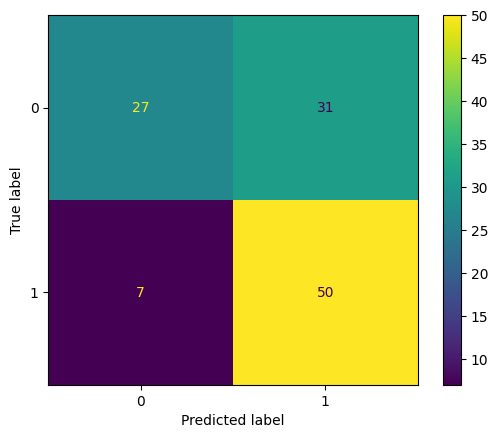

In [10]:
predicted = model.predict(df1)
tensor = torch.tensor(output_rows.values)
predic = tf.squeeze(predicted)


predict= np.array([np.argmax(row) for row in predic])
actual = np.array([np.argmax(row) for row in tensor])
conf_mat = confusion_matrix(actual, predict)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()

In [14]:
from sklearn.metrics import classification_report

print(classification_report(actual, predict))

              precision    recall  f1-score   support

           0       0.79      0.47      0.59        58
           1       0.62      0.88      0.72        57

    accuracy                           0.67       115
   macro avg       0.71      0.67      0.66       115
weighted avg       0.71      0.67      0.66       115



Here is the confusion matrix and classification report for the model. As we can see the model is more likely to guess bad then good.

In [11]:
def total_row_score(vector):
    vector[0][9] = sum(vector[0][0:9])
    vector[1][9] = sum(vector[1][0:9])
    print(vector)

In [17]:

xnew = np.array([[12, 0, 3, 0, 0, 6, 8, 0 ,3, 0],
                 [12, 0, 3, 0, 0, 6,8, 0, 3, 0]])

total_row_score(xnew)


new_prediction = model.predict(xnew.reshape(1,20))
new_prediction = tf.squeeze(new_prediction)

print(new_prediction)
predict_round(new_prediction)

[[12  0  3  0  0  6  8  0  3 32]
 [12  0  3  0  0  6  8  0  3 32]]
1/1 [==============================] - 0s 17ms/step


tf.Tensor([5.1979416e-05 9.9994802e-01], shape=(2,), dtype=float32)


'The estimate would be class 2 with a probability of 99.99480438232422'

Here `xnew` is a test case of our model, at the output is the prediction of class. The input mimics the input of which the model is trained on, and the output is the prediction of the class. But the problem with out neural network appears now, the model is more or less only guess class 2, which is good no matter how the input looks like.
